In [1]:
#!pip install dateparser

# ----------------------------------------------
# 1. Cargar librerías
# ----------------------------------------------

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import openai
import time

In [24]:
from openai import OpenAI
import os

# Inicializar cliente con tu API Key (usando variable de entorno)
client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

🧪 Verificación rápida

In [25]:
import os
print("OPENAI_API_KEY" in os.environ)

True


In [23]:
import openai

openai.api_key = "OPENAI_API_KEY"

try:
    models = openai.models.list()
    print("✅ Tu API key es válida. Modelos disponibles:")
    for model in models['data']:
        print("-", model.id)
except Exception as e:
    print("❌ Error al verificar la API Key:")
    print(e)


❌ Error al verificar la API Key:
Error code: 401 - {'error': {'message': 'Incorrect API key provided: OPENAI_A**_KEY. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


# ----------------------------------------------
# 2. Cargar tu archivo original
# ----------------------------------------------

In [11]:
# Asegúrate que tu archivo esté en el mismo directorio
df = pd.read_csv("llm_input_text_dataset.csv")  # Debe contener una columna 'text' y 'date'

# Inicializar columnas para los resultados
df["fiscal_risk_score"] = None        # Puntaje del 1 al 5
df["risk_index"] = None               # Normalizado a escala 0.0–1.0

In [12]:
# Asegurar columnas necesarias
assert 'text' in df.columns, "Falta columna 'text' con los párrafos"
assert 'date' in df.columns, "Falta columna 'date' con la fecha del documento"

In [13]:
df.head(20)

,title,doc_type,doc_id,year,date,page,paragraph_id,text,fiscal_risk_score,risk_index
0,Informe CF N° 001-2016 – Opinión del Consejo F...,Informe,1.0,2016,2016-01-28,1,3,"En ese sentido, el Consejo Fiscal, en reunione...",None,None
1,Informe CF N° 001-2016 – Opinión del Consejo F...,Informe,1.0,2016,2016-01-28,1,4,"De acuerdo a lo señalado por el MEF, es necesa...",None,None
2,Informe CF N° 001-2016 – Opinión del Consejo F...,Informe,1.0,2016,2016-01-28,1,5,"Por otro lado, mediante la Cuadragésima Tercer...",None,None
3,Informe CF N° 001-2016 – Opinión del Consejo F...,Informe,1.0,2016,2016-01-28,1,6,En virtud de la Segunda Disposición Complement...,None,None
4,Informe CF N° 001-2016 – Opinión del Consejo F...,Informe,1.0,2016,2016-01-28,1,7,Opinión del Consejo Fiscal sobre la nueva meto...,None,None
5,Informe CF N° 001-2016 – Opinión del Consejo F...,Informe,1.0,2016,2016-01-28,1,10,El presente informe contiene la opinión técnic...,None,None
6,Informe CF N° 001-2016 – Opinión del Consejo F...,Informe,1.0,2016,2016-01-28,2,1,"Asimismo, en cuanto al proceso de revisión y a...",None,None
7,Informe CF N° 001-2016 – Opinión del Consejo F...,Informe,1.0,2016,2016-01-28,2,2,El Consejo Fiscal coincide con el MEF en que l...,None,None
8,Informe CF N° 001-2016 – Opinión del Consejo F...,Informe,1.0,2016,2016-01-28,2,8,Respecto a la metodología de cálculo del resul...,None,None
9,Informe CF N° 001-2016 – Opinión del Consejo F...,Informe,1.0,2016,2016-01-28,2,9,Índices de precios de minerales y de hidrocarb...,None,None


In [14]:
df["date"].dtype

dtype('O')

## to date

In [17]:
import pandas as pd

def convert_date_column(df):
    """
    Convierte la columna 'date' a tipo datetime si existe en el DataFrame.
    
    Argumento:
    - df: pandas.DataFrame
    
    Retorna:
    - df: pandas.DataFrame con la columna 'date' convertida, si corresponde.
    """
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
    return df


In [18]:
df = convert_date_column(df)

In [20]:
df["date"].dtype

dtype('<M8[ns]')

In [21]:
df.head(10)

,title,doc_type,doc_id,year,date,page,paragraph_id,text,fiscal_risk_score,risk_index
0,Informe CF N° 001-2016 – Opinión del Consejo F...,Informe,1.0,2016,2016-01-28,1,3,"En ese sentido, el Consejo Fiscal, en reunione...",None,None
1,Informe CF N° 001-2016 – Opinión del Consejo F...,Informe,1.0,2016,2016-01-28,1,4,"De acuerdo a lo señalado por el MEF, es necesa...",None,None
2,Informe CF N° 001-2016 – Opinión del Consejo F...,Informe,1.0,2016,2016-01-28,1,5,"Por otro lado, mediante la Cuadragésima Tercer...",None,None
3,Informe CF N° 001-2016 – Opinión del Consejo F...,Informe,1.0,2016,2016-01-28,1,6,En virtud de la Segunda Disposición Complement...,None,None
4,Informe CF N° 001-2016 – Opinión del Consejo F...,Informe,1.0,2016,2016-01-28,1,7,Opinión del Consejo Fiscal sobre la nueva meto...,None,None
5,Informe CF N° 001-2016 – Opinión del Consejo F...,Informe,1.0,2016,2016-01-28,1,10,El presente informe contiene la opinión técnic...,None,None
6,Informe CF N° 001-2016 – Opinión del Consejo F...,Informe,1.0,2016,2016-01-28,2,1,"Asimismo, en cuanto al proceso de revisión y a...",None,None
7,Informe CF N° 001-2016 – Opinión del Consejo F...,Informe,1.0,2016,2016-01-28,2,2,El Consejo Fiscal coincide con el MEF en que l...,None,None
8,Informe CF N° 001-2016 – Opinión del Consejo F...,Informe,1.0,2016,2016-01-28,2,8,Respecto a la metodología de cálculo del resul...,None,None
9,Informe CF N° 001-2016 – Opinión del Consejo F...,Informe,1.0,2016,2016-01-28,2,9,Índices de precios de minerales y de hidrocarb...,None,None


# ----------------------------------------------
# 3. Función para obtener score desde GPT (1–5)
# ----------------------------------------------

In [26]:
context = """
Sabemos que desde aproximadamente 2016 el manejo de las finanzas públicas ha mostrado signos crecientes de deterioro. 
La pérdida de disciplina fiscal, la falta de transparencia y el relajamiento de las reglas fiscales han sido temas 
recurrentes en los informes del Consejo. A ello se suma el impacto de la inestabilidad política —con frecuentes cambios 
ministeriales— sobre la capacidad institucional para llevar una política fiscal prudente y sostenible. En este contexto, 
el Consejo ha venido alertando con más frecuencia y firmeza sobre el incumplimiento de metas fiscales, el deterioro del 
balance público, y los riesgos de un endeudamiento creciente y potencialmente insostenible.

Criterios comunes en los informes del Consejo Fiscal (según categoría):

1. Cumplimiento y disciplina fiscal:
(disciplina fiscal, incumplimiento de metas fiscales, relajamiento de reglas fiscales, uso inadecuado del gasto público, desviación del déficit fiscal, deterioro del marco fiscal, flexibilización sin justificación, política fiscal procíclica)

2. Riesgo y sostenibilidad:
(riesgo fiscal, riesgo de sostenibilidad de la deuda, endeudamiento excesivo, dependencia de ingresos extraordinarios, vulnerabilidad fiscal estructural, uso de medidas transitorias o no permanentes, incertidumbre macrofiscal)

3. Gobernanza e institucionalidad:
(transparencia fiscal, calidad del gasto público, incertidumbre institucional, falta de planificación multianual, cambios frecuentes en autoridades económicas, debilitamiento institucional, independencia fiscal comprometida, ausencia de reforma estructural)
"""

    """
    Evalúa un párrafo de un informe fiscal utilizando GPT-4o y asigna un score del 1 al 5
    según el nivel de preocupación o alarma fiscal expresado.

    Returns:
        - int (1 a 5): Score de riesgo fiscal asignado por el modelo
        - None: En caso de error o respuesta inválida
    """

Interpretación:
- 1 = Sin preocupación fiscal (consolidación fiscal sostenida, cumplimiento de metas, transparencia fiscal, calidad del gasto público, planificación multianual)
- 2 = Ligera preocupación (observaciones menores, advertencias marginales, riesgo fiscal potencial, uso de medidas transitorias o ingresos extraordinarios)
- 3 = Neutral (descripción técnica sin énfasis positivo ni negativo, gestión fiscal dentro del marco previsto)
- 4 = Alta preocupación (incumplimiento de metas, flexibilización sin justificación, incertidumbre macrofiscal, debilitamiento institucional)
- 5 = Alarma fiscal (críticas severas, endeudamiento excesivo, deterioro del marco fiscal, independencia fiscal comprometida)

In [27]:
def get_llm_score(text):
    prompt = f"""
Eres un analista técnico del Consejo Fiscal de Perú. Evalúa el siguiente párrafo extraído de un informe técnico del Consejo Fiscal (CF), donde se emite una opinión sobre el desempeño fiscal del Ministerio de Economía y Finanzas (MEF) en cuanto al cumplimiento de las metas fiscales.

Tu tarea es asignar un **puntaje del 1 al 5** según el **nivel de preocupación o alerta fiscal expresado en el texto**.

Interpretación:
- 1 = Sin preocupación fiscal (cumplimiento de metas, transparencia fiscal, planificación multianual)
- 2 = Ligera preocupación (riesgo fiscal potencial, desviación del déficit, dependencia de ingresos extraordinarios)
- 3 = Neutral (descripción técnica, gestión dentro del marco, sin juicio valorativo)
- 4 = Alta preocupación (incumplimiento de metas, relajamiento fiscal, incertidumbre macroeconómica)
- 5 = Alarma fiscal (críticas severas, riesgo de sostenibilidad de la deuda, independencia fiscal comprometida)

Devuelve solo un número del 1 al 5.

Texto:
\"\"\"{text}\"\"\"
""".strip()

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            max_tokens=5,
        )
        result = response.choices[0].message.content.strip()
        if result in {'1', '2', '3', '4', '5'}:
            return int(result)
        else:
            print(f"⚠️ Respuesta inesperada: {result}")
            return None
    except Exception as e:
        print(f"❌ Error: {e}")
        return None


# ----------------------------------------------
# 4. Ejecutar clasificación (con backup y control de crédito)
# ----------------------------------------------

In [28]:
import openai
print(openai.__version__)


1.91.0


In [29]:
from datetime import datetime

start = time.time()

for i, row in df.iterrows():
    if pd.notna(row["fiscal_risk_score"]):
        continue  # Ya procesado

    score = get_llm_score(row["text"])

    # Guardar score
    df.at[i, "fiscal_risk_score"] = score
    df.at[i, "risk_index"] = score / 5 if score else None

    # Backup cada 10 filas
    if i % 10 == 0:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        df.to_csv(f"backup_fiscal_risk_{timestamp}.csv", index=False)
        print(f"💾 Backup guardado en fila {i} - {timestamp}")

    time.sleep(1.2)  # Control para no sobrecargar

end = time.time()
print(f"✅ Proceso completado en {round((end - start)/60, 2)} minutos.")



💾 Backup guardado en fila 0 - 20250716_135709
💾 Backup guardado en fila 10 - 20250716_135729
💾 Backup guardado en fila 20 - 20250716_135749
💾 Backup guardado en fila 30 - 20250716_135808
💾 Backup guardado en fila 40 - 20250716_135825
💾 Backup guardado en fila 50 - 20250716_135843
💾 Backup guardado en fila 60 - 20250716_135901
💾 Backup guardado en fila 70 - 20250716_135954
💾 Backup guardado en fila 80 - 20250716_140023
💾 Backup guardado en fila 90 - 20250716_140040
💾 Backup guardado en fila 100 - 20250716_140057
💾 Backup guardado en fila 110 - 20250716_140115
💾 Backup guardado en fila 120 - 20250716_140132
💾 Backup guardado en fila 130 - 20250716_140150
💾 Backup guardado en fila 140 - 20250716_140207
💾 Backup guardado en fila 150 - 20250716_140224
💾 Backup guardado en fila 160 - 20250716_140241
💾 Backup guardado en fila 170 - 20250716_140259
💾 Backup guardado en fila 180 - 20250716_140316
💾 Backup guardado en fila 190 - 20250716_140335
💾 Backup guardado en fila 200 - 20250716_140353
💾 B

💾 Backup guardado en fila 1660 - 20250716_150132
💾 Backup guardado en fila 1670 - 20250716_150149
💾 Backup guardado en fila 1680 - 20250716_150208
💾 Backup guardado en fila 1690 - 20250716_150226
💾 Backup guardado en fila 1700 - 20250716_150245
💾 Backup guardado en fila 1710 - 20250716_150302
💾 Backup guardado en fila 1720 - 20250716_150320
💾 Backup guardado en fila 1730 - 20250716_150338
💾 Backup guardado en fila 1740 - 20250716_150357
💾 Backup guardado en fila 1750 - 20250716_150415
💾 Backup guardado en fila 1760 - 20250716_150434
💾 Backup guardado en fila 1770 - 20250716_150452
💾 Backup guardado en fila 1780 - 20250716_150513
💾 Backup guardado en fila 1790 - 20250716_150532
💾 Backup guardado en fila 1800 - 20250716_150550
💾 Backup guardado en fila 1810 - 20250716_150609
💾 Backup guardado en fila 1820 - 20250716_150627
💾 Backup guardado en fila 1830 - 20250716_150645
💾 Backup guardado en fila 1840 - 20250716_150703
💾 Backup guardado en fila 1850 - 20250716_150721
💾 Backup guardado en

# Guardar resultados completos

In [30]:
df.to_csv("df_fiscal_scored.csv", index=False)

In [31]:
df.head(5)

,title,doc_type,doc_id,year,date,page,paragraph_id,text,fiscal_risk_score,risk_index
0,Informe CF N° 001-2016 – Opinión del Consejo F...,Informe,1.0,2016,2016-01-28,1,3,"En ese sentido, el Consejo Fiscal, en reunione...",3,0.6
1,Informe CF N° 001-2016 – Opinión del Consejo F...,Informe,1.0,2016,2016-01-28,1,4,"De acuerdo a lo señalado por el MEF, es necesa...",2,0.4
2,Informe CF N° 001-2016 – Opinión del Consejo F...,Informe,1.0,2016,2016-01-28,1,5,"Por otro lado, mediante la Cuadragésima Tercer...",3,0.6
3,Informe CF N° 001-2016 – Opinión del Consejo F...,Informe,1.0,2016,2016-01-28,1,6,En virtud de la Segunda Disposición Complement...,3,0.6
4,Informe CF N° 001-2016 – Opinión del Consejo F...,Informe,1.0,2016,2016-01-28,1,7,Opinión del Consejo Fiscal sobre la nueva meto...,3,0.6


# Fleeting inspect

In [32]:
df["fiscal_risk_score"].value_counts(dropna=False).sort_index()

fiscal_risk_score
1       143
2       472
3       555
4       693
5        79
None      1
Name: count, dtype: int64

In [33]:
df["risk_index"].describe()

count     1942.0
unique       5.0
top          0.8
freq       693.0
Name: risk_index, dtype: float64

# ----------------------------------------------
# 5. Agregar score promedio por fecha
# ----------------------------------------------

# Aggregation

In [35]:
df_doc_avg = df.groupby(['title', 'date']).agg(
    avg_risk_score=('fiscal_risk_score', 'mean'),
    avg_risk_index=('risk_index', 'mean'),
    n_paragraphs=('fiscal_risk_score', 'count')
).reset_index()

In [36]:
df_doc_avg

,title,date,avg_risk_score,avg_risk_index,n_paragraphs
0,Comunicado N° 01-2022-CF Comunicado del Consej...,2022-01-14,4.285714,0.857143,7
1,Comunicado N° 01-2023-CF Comunicado del Consej...,2023-03-02,3.0,0.6,6
2,Comunicado N° 01-2024-CF – El Consejo Fiscal a...,2024-02-01,3.846154,0.769231,13
3,Comunicado N° 01-2025-CF – El Consejo Fiscal e...,2025-01-20,3.645161,0.729032,31
4,Comunicado N° 02-2022-CF Comunicado del Consej...,2022-05-24,4.4,0.88,5
...,...,...,...,...,...
67,Informe N° 05-2024-CF – Opinión del Consejo Fi...,2024-08-23,3.319444,0.663889,72
68,Informe N° 06-2021-CF Opinión del Consejo Fisc...,2021-12-20,2.8125,0.5625,32
69,Informe N°002-2019-CF Opinión del Consejo Fisc...,2019-05-21,2.7,0.54,40
70,Informe N°003-2019-CF Opinión del Consejo Fisc...,2019-06-06,2.612903,0.522581,31


In [38]:
df_score_dist = (
    df.pivot_table(index=['title', 'date'], 
                   columns='fiscal_risk_score', 
                   values='text', 
                   aggfunc='count', 
                   fill_value=0)
    .reset_index()
    .rename(columns={1: 'score_1', 2: 'score_2', 3: 'score_3', 4: 'score_4', 5: 'score_5'})
)


In [39]:
df_score_dist

fiscal_risk_score,title,date,score_1,score_2,score_3,score_4,score_5
0,Comunicado N° 01-2022-CF Comunicado del Consej...,2022-01-14,0,0,0,5,2
1,Comunicado N° 01-2023-CF Comunicado del Consej...,2023-03-02,0,2,2,2,0
2,Comunicado N° 01-2024-CF – El Consejo Fiscal a...,2024-02-01,0,1,1,10,1
3,Comunicado N° 01-2025-CF – El Consejo Fiscal e...,2025-01-20,2,0,6,22,1
4,Comunicado N° 02-2022-CF Comunicado del Consej...,2022-05-24,0,0,0,3,2
...,...,...,...,...,...,...,...
67,Informe N° 05-2024-CF – Opinión del Consejo Fi...,2024-08-23,1,16,16,37,2
68,Informe N° 06-2021-CF Opinión del Consejo Fisc...,2021-12-20,0,13,12,7,0
69,Informe N°002-2019-CF Opinión del Consejo Fisc...,2019-05-21,4,10,20,6,0
70,Informe N°003-2019-CF Opinión del Consejo Fisc...,2019-06-06,7,6,10,8,0


In [40]:
score_cols = ['score_1', 'score_2', 'score_3', 'score_4', 'score_5']
df_score_dist[score_cols] = df_score_dist[score_cols].div(df_score_dist[score_cols].sum(axis=1), axis=0)


In [41]:
df_score_dist

fiscal_risk_score,title,date,score_1,score_2,score_3,score_4,score_5
0,Comunicado N° 01-2022-CF Comunicado del Consej...,2022-01-14,0.000000,0.000000,0.000000,0.714286,0.285714
1,Comunicado N° 01-2023-CF Comunicado del Consej...,2023-03-02,0.000000,0.333333,0.333333,0.333333,0.000000
2,Comunicado N° 01-2024-CF – El Consejo Fiscal a...,2024-02-01,0.000000,0.076923,0.076923,0.769231,0.076923
3,Comunicado N° 01-2025-CF – El Consejo Fiscal e...,2025-01-20,0.064516,0.000000,0.193548,0.709677,0.032258
4,Comunicado N° 02-2022-CF Comunicado del Consej...,2022-05-24,0.000000,0.000000,0.000000,0.600000,0.400000
...,...,...,...,...,...,...,...
67,Informe N° 05-2024-CF – Opinión del Consejo Fi...,2024-08-23,0.013889,0.222222,0.222222,0.513889,0.027778
68,Informe N° 06-2021-CF Opinión del Consejo Fisc...,2021-12-20,0.000000,0.406250,0.375000,0.218750,0.000000
69,Informe N°002-2019-CF Opinión del Consejo Fisc...,2019-05-21,0.100000,0.250000,0.500000,0.150000,0.000000
70,Informe N°003-2019-CF Opinión del Consejo Fisc...,2019-06-06,0.225806,0.193548,0.322581,0.258065,0.000000


In [44]:
df_doc_summary = pd.merge(df_doc_avg, df_score_dist, on=['title', 'date'])


In [45]:
df_doc_summary

,title,date,avg_risk_score,avg_risk_index,n_paragraphs,score_1,score_2,score_3,score_4,score_5
0,Comunicado N° 01-2022-CF Comunicado del Consej...,2022-01-14,4.285714,0.857143,7,0.000000,0.000000,0.000000,0.714286,0.285714
1,Comunicado N° 01-2023-CF Comunicado del Consej...,2023-03-02,3.0,0.6,6,0.000000,0.333333,0.333333,0.333333,0.000000
2,Comunicado N° 01-2024-CF – El Consejo Fiscal a...,2024-02-01,3.846154,0.769231,13,0.000000,0.076923,0.076923,0.769231,0.076923
3,Comunicado N° 01-2025-CF – El Consejo Fiscal e...,2025-01-20,3.645161,0.729032,31,0.064516,0.000000,0.193548,0.709677,0.032258
4,Comunicado N° 02-2022-CF Comunicado del Consej...,2022-05-24,4.4,0.88,5,0.000000,0.000000,0.000000,0.600000,0.400000
...,...,...,...,...,...,...,...,...,...,...
67,Informe N° 05-2024-CF – Opinión del Consejo Fi...,2024-08-23,3.319444,0.663889,72,0.013889,0.222222,0.222222,0.513889,0.027778
68,Informe N° 06-2021-CF Opinión del Consejo Fisc...,2021-12-20,2.8125,0.5625,32,0.000000,0.406250,0.375000,0.218750,0.000000
69,Informe N°002-2019-CF Opinión del Consejo Fisc...,2019-05-21,2.7,0.54,40,0.100000,0.250000,0.500000,0.150000,0.000000
70,Informe N°003-2019-CF Opinión del Consejo Fisc...,2019-06-06,2.612903,0.522581,31,0.225806,0.193548,0.322581,0.258065,0.000000


# ----------------------------------------------
# 6. Visualizar índice fiscal
# ----------------------------------------------

# CMA

In [46]:
df_doc_summary = df_doc_summary.sort_values("date")

In [47]:
# Calcula la media móvil centrada con ventana de 3 documentos
df_doc_summary["cma_risk_index"] = df_doc_summary["avg_risk_index"].rolling(window=3, center=True).mean()


$$
\text{CMA}_t = \frac{4X_{t-1} + 2X_t + X_{t+1}}{7}
$$

# Áreas apiladas

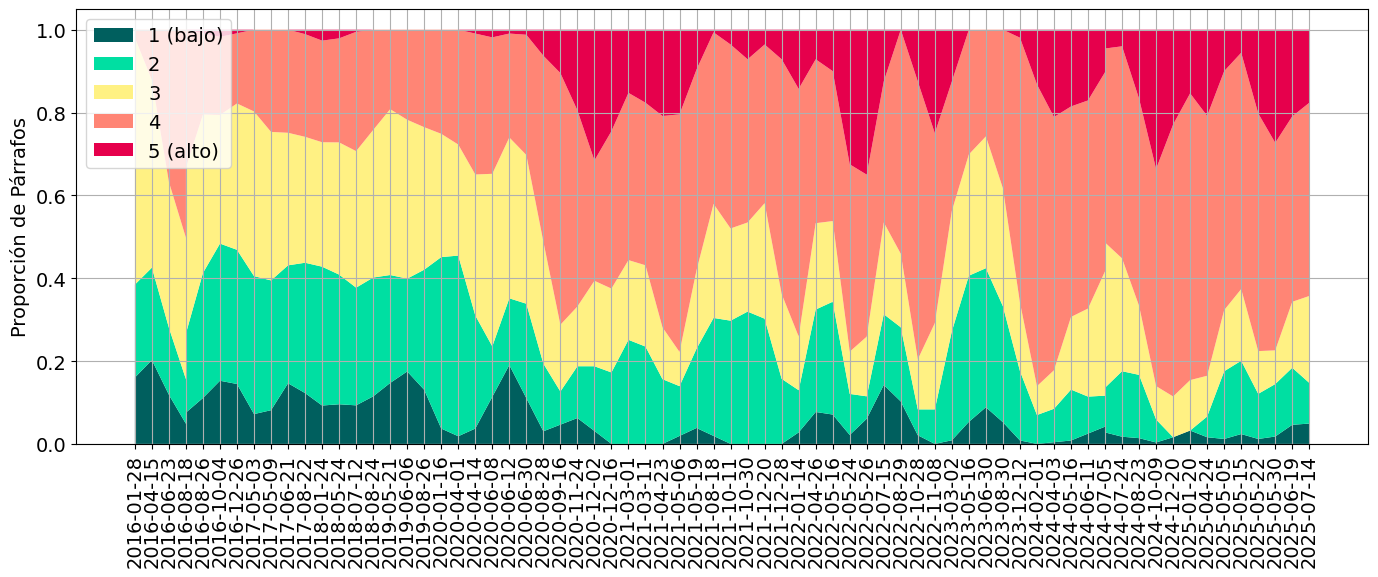

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Asegurar orden por fecha
df_doc_summary = df_doc_summary.sort_values("date").reset_index(drop=True)
df_doc_summary['date_str'] = df_doc_summary['date'].dt.strftime('%Y-%m-%d')

# Pesos del suavizamiento
weights = np.array([1, 2, 1])

# Aplicar CMA con bordes extendidos a cada score
for col in ['score_1', 'score_2', 'score_3', 'score_4', 'score_5']:
    series = df_doc_summary[col].copy()

    middle_cma = (
        series.rolling(window=3, center=True)
        .apply(lambda x: np.dot(x, weights) / 4, raw=True)
    )

    # Bordes
    first = series.iloc[0]
    second = series.iloc[1]
    first_smoothed = (3 * first + second) / 4

    last = series.iloc[-1]
    penultimate = series.iloc[-2]
    last_smoothed = (3 * last + penultimate) / 4

    # Insertar bordes
    middle_cma.iloc[0] = first_smoothed
    middle_cma.iloc[-1] = last_smoothed

    df_doc_summary[f'{col}_cma'] = middle_cma

# Configuración para el gráfico
cols_cma = ['score_1_cma', 'score_2_cma', 'score_3_cma', 'score_4_cma', 'score_5_cma']
labels = ['1 (bajo)', '2', '3', '4', '5 (alto)']
colors = ['#005f5e', '#00DFA2', '#FFF183', '#ff8575', '#E6004C']

# Gráfico de áreas apiladas suavizadas
plt.figure(figsize=(14, 6))
plt.stackplot(df_doc_summary['date_str'], 
              *[df_doc_summary[col] for col in cols_cma],
              labels=labels,
              colors=colors)

plt.ylabel("Proporción de Párrafos", fontsize=14)
plt.xticks(rotation=90)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()

# Guardar gráfico
plt.savefig("stacked_areas.png", dpi=300)
plt.show()



# Index

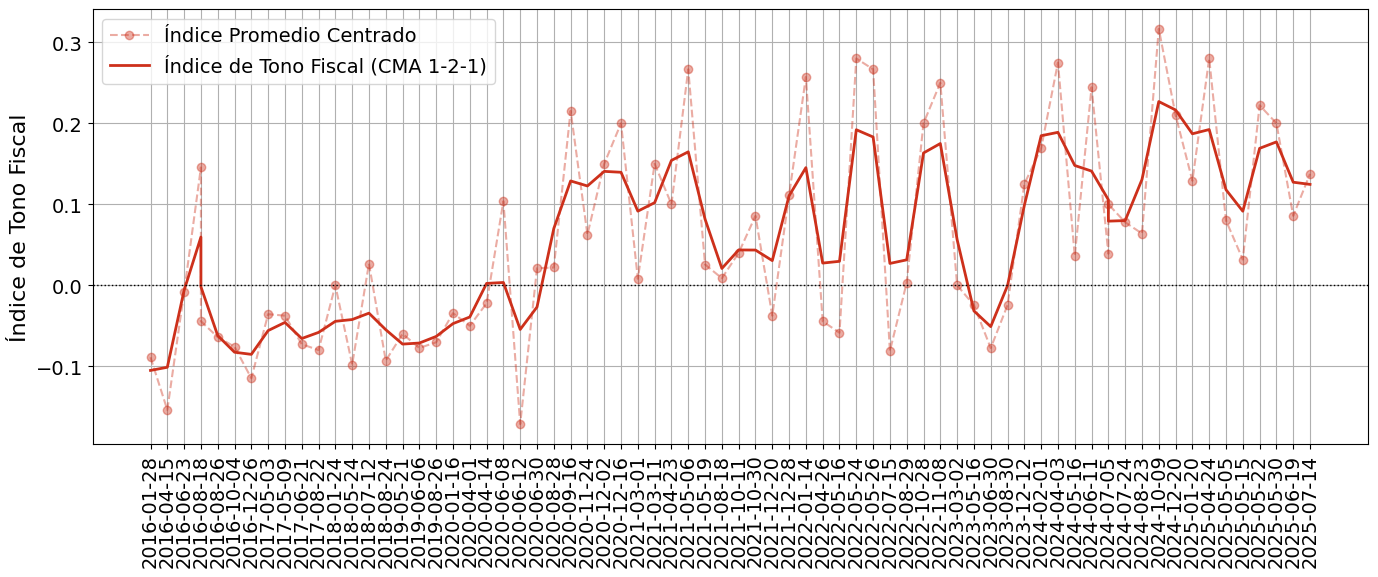

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Calcular el índice promedio centrado
df_doc_summary["avg_risk_index_centered"] = df_doc_summary["avg_risk_index"] - 0.6

# 2. Aplicar suavizamiento CMA (1-2-1) con extremos refinados
weights = np.array([1, 2, 1])
series = df_doc_summary["avg_risk_index_centered"].copy()

# CMA centrado
cma = series.rolling(window=3, center=True).apply(lambda x: np.dot(x, weights)/4, raw=True)

# Bordes corregidos
first = series.iloc[0]
second = series.iloc[1]
cma.iloc[0] = (3 * first + second) / 4

last = series.iloc[-1]
penultimate = series.iloc[-2]
cma.iloc[-1] = (3 * last + penultimate) / 4

# Guardar resultado
df_doc_summary["avg_risk_index_centered_cma"] = cma

# 3. Graficar y guardar como PNG
plt.figure(figsize=(14, 6))

# Serie original (transparente)
plt.plot(df_doc_summary["date_str"], df_doc_summary["avg_risk_index_centered"],
         label="Índice Promedio Centrado", linestyle='--',
         marker='o', alpha=0.4, color="#cd301b")

# Serie suavizada
plt.plot(df_doc_summary["date_str"], df_doc_summary["avg_risk_index_centered_cma"],
         label="Índice de Tono Fiscal (CMA 1-2-1)", linewidth=2, color="#cd301b")

# Eje horizontal en cero
plt.axhline(0, color='black', linestyle=':', linewidth=1)

# Estética
plt.ylabel("Índice de Tono Fiscal", fontsize = 16)
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Guardar como PNG
plt.savefig("fiscal_tone_index.png", dpi=300)
#plt.close()
plt.show()
